## Notebook objectives

Cluster Segmentation on geolocation.


## Agenda

[Business Context](#Business-Context)<br> 
&emsp;[Business Questions](#Business-Questions)<br>

[Imports](#Imports)<br>
&emsp;[Helper Functions and Classes](#Helper-Functions-and-Classes)<br>


[Settings](#Settings)<br>

[Loading Data](#Loading-Data)<br>
&emsp;[df_payments](#df_payments)<br>
&emsp;[df_products](#df_products)<br>
&emsp;[df_order_items](#df_order_items)<br>
&emsp;[df_geolocations](#df_geolocations)<br>
&emsp;[df_customers](#df_customers)<br>


[Analytical Base Table](#Analytical-Base-Table)<br>
&emsp;[ABT Metadata](#ABT-Metadata)<br>
&emsp;[df_payment_abt](#df_payment_abt)<br>
&emsp;[df_orders_abt](#df_orders_abt)<br>
&emsp;[df_geolocation_abt](#df_geolocation_abt)<br>

[Feature Selection](#Feature-Selection)<br>

[Preprocessing](#Preprocessing)<br>

[Clustering](#Clustering)<br>
&emsp;[K-Means](#K-Means)<br>
&emsp;[DBSCAN](#DBSCAN)<br>
&emsp;[Agglomerative Clustering](#Agglomerative-Clustering)<br>

[Feature Importances](#Feature-Importances)<br>

[Analysis](#Analysis)<br>

[Final Clusters](#Final-Clusters)<br>



## Business Context

E-Mart is a Chinese retailer that discovered the e-commerce as a way to sell to the entire world, rather than just to the population of their home city. The company has been growing without much worries, and now It wants to start using the data collected during its 4 years of e-commerce to keep growing and make more money.


The company has been growing without much worries, and now It wants to start using the data collected during the years to keep growing and make more money.
At first, the board of directors expects:

- A Dashboard with KPIs to track their growth.
<br>

- Robust Data Analysis, as well as recommendation of actions. What's the actionable based on your analysis?
<br>

- **An Analysis on geolocation, a segmentation by sales, profit and more. They want insights to help increasing revenue.**
<br>

- Sales forecast for the next year, in order to enable strategic planning.



### Business Questions

**How can we group markets by geolocation and profit from it?**

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

### Helper Functions and Classes

In [2]:
def get_snakecase_columns(df):
    """Sets column name to snake_case format
    
    df: pandas.DataFrame
    
    Return: map
    """
    snakecase = lambda x: str(x).lower().replace(' ', '_').replace('-', '_')
    return map(snakecase, df.columns)

def date(str_date):
    """Apply pandas.to_datetime to argument converting it to datetime.
        
    """
    return pd.to_datetime(str_date)

def find_column(df, col_name):
    """Checks if DataFrame contains a 'column name' and returns the matched columns
    
    df: pandas.DataFrame
    col_name: column name or part of column name to search for
    
    Return: DataFrame with column names that match the col_name searched
    """
    
    df_cols = pd.DataFrame(df.columns, columns=['col_name'])

    return df_cols[df_cols['col_name'].str.contains(col_name)].reset_index(drop=True)


def fig(x=15, y=5, set_as_global=False, reset_to_default=False):
    """ Adjust size of matplotlib figure

    x: figure width.
    y: figure height.
    set_as_global: bool.
        If True, then it sets "x" and "y" axis for all subsequent plots.
    reset_to_default: bool.
        If True, then it resets the global figure size back to default.
    """
    if set_as_global:
        plt.rcParams["figure.figsize"] = (x, y)
    elif reset_to_default:
        plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
    else:
        plt.figure(figsize=(x,y))
        
        
def boxplot(data, x, y, showfliers, yticks_size=20):
    sns.boxplot(data=data, x=x, y=y, showfliers=showfliers);
    plt.ylabel(y, size=24)
    plt.xticks(rotation=90);
    plt.yticks(size=yticks_size);
    
    
def cluster_boxplot(cluster, y, data, showfliers=False, xticks_rotation=0, figsize=(15, 5)):
    fig(figsize[0], figsize[1])
    plt.subplot( 1, 2, 1 )
    sns.boxplot( x=cluster, y=y[0], data=data, showfliers=showfliers)
    plt.xticks(rotation=xticks_rotation)
    plt.subplot( 1, 2, 2 )
    sns.boxplot( x=cluster, y=y[1], data=data, showfliers=showfliers)
    plt.xticks(rotation=xticks_rotation)
    
def count_plot(data, cluster_col="cluster", palette='crest_r', title='countplot'):
    plt.box(False)
    ax = sns.countplot(y=cluster_col, data=data, palette=palette)
    plt.title(title)
    plt.tick_params(axis='both', length=0)
    plt.xlabel(None)
    for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_width()), (p.get_width()+5, p.get_y()+.5))
        

### Settings

In [3]:
pd.set_option('display.max_columns', 500)

fig(12,4, set_as_global=True)

## Loading Data

### df_orders

In [4]:
df_orders = pd.read_csv("https://raw.githubusercontent.com/pauloreisdatascience/datasets/main/e_market/e_mart_orders_table.csv")
df_orders.columns = get_snakecase_columns(df_orders)

df_orders['customer_id'] = df_orders['customer_id'].apply(lambda x: x[2:-2])
df_orders['order_date'] = df_orders['order_date'].apply(date)
df_orders['ship_date'] = df_orders['ship_date'].apply(date)
df_orders['delivery_date'] = df_orders['delivery_date'].apply(date)
df_orders['deadline_date'] = df_orders['deadline_date'].apply(date)
df_orders['order_priority'] = df_orders['order_priority'].apply(lambda x: x[2:-2])
df_orders = df_orders.assign(postal_code=df_orders['postal_code'].apply(lambda x: int(x[2:-2])))

In [5]:
df_orders.duplicated(subset=['order_id']).sum()

0

### df_payments

In [6]:
df_payments = pd.read_csv("https://raw.githubusercontent.com/pauloreisdatascience/datasets/main/e_market/e_mart_payment_table.csv")
df_payments.columns = get_snakecase_columns(df_payments)

In [7]:
df_payments.duplicated(subset=['order_id']).sum()

0

### df_products

In [8]:
df_products = pd.read_csv("https://raw.githubusercontent.com/pauloreisdatascience/datasets/main/e_market/e_mart_products_table.csv")
df_products.columns = get_snakecase_columns(df_products)

In [9]:
df_products.duplicated(subset=['product_id']).sum()

0

### df_order_items

In [10]:
df_order_items = pd.read_csv("https://raw.githubusercontent.com/pauloreisdatascience/datasets/main/e_market/e_mart_order_items_table.csv")
df_order_items.columns = get_snakecase_columns(df_order_items)

In [11]:
df_order_items.duplicated(subset=['order_item_id']).sum()

35

### df_geolocations

In [12]:
df_geolocations = pd.read_csv("https://raw.githubusercontent.com/pauloreisdatascience/datasets/main/e_market/e_mart_geolocation_table.csv")
df_geolocations.columns = get_snakecase_columns(df_geolocations)

In [13]:
df_geolocations.duplicated(subset=['postal_code']).sum()

0

### df_customers

In [14]:
df_customers = pd.read_csv("https://raw.githubusercontent.com/pauloreisdatascience/datasets/main/e_market/e_mart_customers_table.csv")
df_customers.columns = get_snakecase_columns(df_customers)

In [15]:
df_customers.duplicated(subset=['customer_id']).sum()

0

## Analytical Base Table

### ABT Metadata

[df_orders_abt](#df_orders_abt)<br>



### df_payment_abt

In [16]:
df_payment_abt = df_order_items.merge(df_products, how='left', on=['product_id'])

df_payment_abt['sales'] = (
    (df_payment_abt['quantity']*df_payment_abt['product_price'] *(1-df_payment_abt['discount']))
    + df_payment_abt['shipping_cost']
)

cols = ['order_item_id', 'order_id', 'product_id',
        'quantity', 'product_price', 'discount',
        'shipping_cost', 'sales']
df_payment_abt = df_payment_abt[cols]


df_payment_abt = (
    df_payment_abt.groupby('order_id')
                    .agg(n_products=('quantity', 'sum'),
                         total_discount=('discount', 'sum'),
                         avg_discount=('discount', 'mean'),
                         avg_product_price=('product_price', 'mean'),
                         shipping_cost=('shipping_cost', 'sum'),
                         sales=('sales', 'sum'),
                         max_product_price=('product_price', 'max'),
                         min_product_price=('product_price', 'min')
                        )
)

# Check if Payment and Sales are equal
# df_payment_abt = df_payment_abt.merge(df_payments.rename(columns={'sales':'payment'}),
#                                       how='left', on=['order_id'])

df_payment_abt.head(2)

,n_products,total_discount,avg_discount,avg_product_price,shipping_cost,sales,max_product_price,min_product_price
order_id,,,,,,,,
AE-2011-9160-PO-8865,8,1.4,0.7,110.775909,9.56,176.424976,193.273579,28.278238
AE-2013-1130-EB-4110,7,1.4,0.7,52.947440,60.18,242.152214,100.135833,5.759048


### df_orders_abt


https://www.vuupt.com/post/kpis-do-delivery/

In [17]:
df_orders_abt = (df_orders
         .merge(df_geolocations, how='left', on='postal_code')
         .merge(df_customers, how='left', on='customer_id')
         .merge(df_payments, how='left', on=['order_id'])
)

df_orders_abt['order_date_monthly'] = df_orders_abt['order_date'].dt.to_period("M")#.dt.to_timestamp(freq='M')
df_orders_abt['market_region'] = df_orders_abt['market'] +" | " + df_orders_abt['region']
df_orders_abt['delivery_time'] = (df_orders_abt['delivery_date'] - df_orders_abt['order_date']).dt.days
df_orders_abt['expected_delivery_time'] = (df_orders_abt['deadline_date'] - df_orders_abt['order_date']).dt.days
df_orders_abt['days_to_ship'] = (df_orders_abt['ship_date'] - df_orders_abt['order_date']).dt.days
df_orders_abt['delayed_days'] = df_orders_abt['delivery_time'] - df_orders_abt['expected_delivery_time']
df_orders_abt['delivery_on_time'] = df_orders_abt['delayed_days'].apply(lambda x: True if x <= 0
                                                                        else False)
df_orders_abt['profitable'] = df_orders_abt['profit'].apply(lambda x: True if x>0 else False)

df_orders_abt = df_orders_abt.merge(df_payment_abt.drop(columns=['sales']),
                                    how='left', on=['order_id'])

df_orders_abt.head(2)

,order_id,customer_id,order_date,ship_date,delivery_date,ship_mode,postal_code,market,order_priority,deadline_date,order_status,region,country,state,city,customer_name,segment,sales,profit,order_date_monthly,market_region,delivery_time,expected_delivery_time,days_to_ship,delayed_days,delivery_on_time,profitable,n_products,total_discount,avg_discount,avg_product_price,shipping_cost,max_product_price,min_product_price
0,AE-2011-9160-PO-8865,PO-8865,2019-03-10,2019-03-29,2019-04-01,Standard Class,5137041,EMEA,Medium,2019-04-19,Delivered,EMEA,United Arab Emirates,'Ajman,Ajman,Patrick O'Donnell,Consumer,176.424976,-246.078,2019-03,EMEA | EMEA,22.0,40,19.0,-18.0,True,False,8,1.4,0.7,110.775909,9.56,193.273579,28.278238
1,AE-2013-1130-EB-4110,EB-4110,2021-10-14,2021-10-14,2021-10-23,Same Day,51378252664,EMEA,High,2021-11-23,Delivered,EMEA,United Arab Emirates,Ra's Al Khaymah,Ras al Khaymah,Eugene Barchas,Consumer,242.152214,-236.964,2021-10,EMEA | EMEA,9.0,40,0.0,-31.0,True,False,7,1.4,0.7,52.947440,60.18,100.135833,5.759048


In [18]:
# df_orders_abt.to_csv("../../data/growth_analysis/orders_abt.csv")

### df_geolocation_abt

In [19]:
['market', 'region', 'market_region', 'country', 'state', 'city',]

['market', 'region', 'market_region', 'country', 'state', 'city']

In [20]:
geolocation_group = 'country'
df_geolocation_abt = (
    df_orders_abt.groupby(geolocation_group)
                 .agg(n_orders=('order_id', 'nunique'),
                      n_customers=('customer_id', 'nunique'),
                      n_postal_code=('postal_code', 'nunique'),
                      n_market=('market', 'nunique'),
                      n_region=('region', 'nunique'),
                      n_country=('country', 'nunique'),
                      n_state=('state', 'nunique'),
                      n_city=('city', 'nunique'),
                      total_sales=('sales', 'sum'),
                      avg_sales=('sales', 'mean'),
                      total_profit=('profit', 'sum'),
                      avg_profit=('profit', 'mean'),
                      avg_delivery_time=('delivery_time', 'mean'),
                      avg_days_to_ship=('days_to_ship', 'mean'),
                      avg_delayed_days=('delayed_days', 'mean'),
                      delivery_on_time=('delivery_on_time', 'sum'),
                      on_time_rate=('delivery_on_time', 'mean'),  
                      n_products=('n_products', 'sum'),
                      avg_products_per_order=('n_products', 'mean'),
                      avg_discount=('avg_discount', 'mean'),
                      avg_product_price=('avg_product_price', 'mean'),
                      total_shipping_cost=('shipping_cost', 'sum'),
                      avg_shipping_cost=('shipping_cost', 'mean'),
                      profitable_rate=('profitable', 'mean')
                     )
).reset_index().drop(columns=[f'n_{geolocation_group}'])

df_geolocation_abt['profitable'] = df_geolocation_abt['total_profit'].apply(lambda x: True if x>0 else False)

df_geolocation_abt.head(2)

,country,n_orders,n_customers,n_postal_code,n_market,n_region,n_state,n_city,total_sales,avg_sales,total_profit,avg_profit,avg_delivery_time,avg_days_to_ship,avg_delayed_days,delivery_on_time,on_time_rate,n_products,avg_products_per_order,avg_discount,avg_product_price,total_shipping_cost,avg_shipping_cost,profitable_rate,profitable
0,Afghanistan,26,25,4,1,1,4,4,48043.335029,1847.820578,5460.30,210.011538,21.653846,16.230769,-18.346154,23,0.884615,228,8.769231,0.0,180.468184,2300.23,88.470385,1.0,True
1,Albania,10,10,5,1,1,5,5,3529.399542,352.939954,709.32,70.932000,21.800000,15.700000,-18.200000,9,0.900000,40,4.000000,0.0,97.316638,698.57,69.857000,1.0,True


## Feature Selection

In [21]:
# df_geolocation_abt.columns

In [22]:
features = ['n_orders', 'n_customers', 'n_postal_code', 'n_market',
            'n_region', 'n_state', 'n_city', 'total_sales', 'avg_sales',
            'total_profit', 'avg_profit', 'avg_delivery_time', 'avg_days_to_ship',
            'avg_delayed_days', 'delivery_on_time', 'on_time_rate', 'n_products',
            'avg_products_per_order', 'avg_discount', 'avg_product_price',
            'total_shipping_cost', 'avg_shipping_cost', 'profitable_rate',
            'profitable']

df_train = df_geolocation_abt[features]

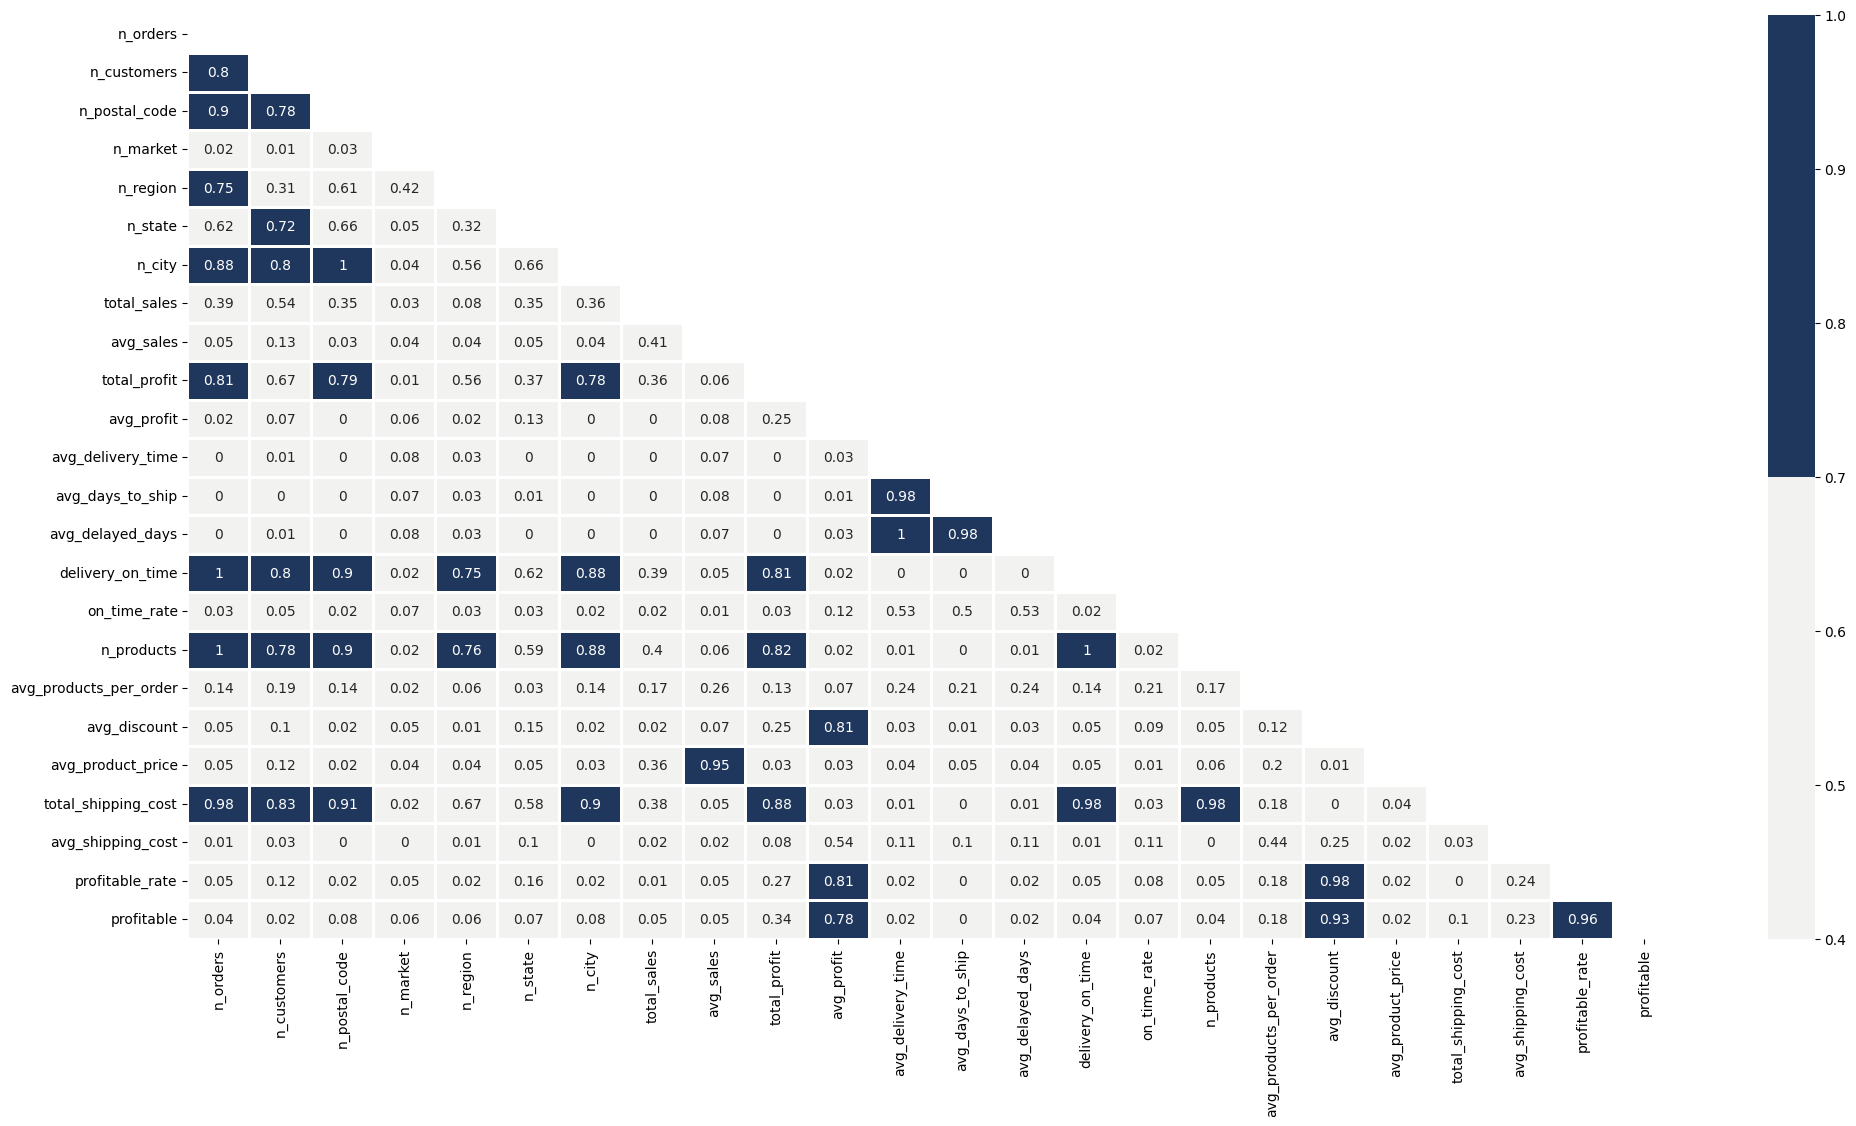

In [23]:
plt.figure(figsize=(24, 12))
correlations = df_train[features].corr().abs().round(2)
mask = np.triu(np.ones_like(correlations, dtype=bool))
sns.heatmap(correlations, mask=mask, linewidths=1, annot=True, cmap=['#F2F2F0','#1F375D'], vmin=0.40) #vmax=-0.40
plt.show()

## Preprocessing

In [24]:
min_max_scaler = MinMaxScaler()
df_train = min_max_scaler.fit_transform(df_train)

In [25]:
df_train = pd.DataFrame(min_max_scaler.fit_transform(df_train),
                        columns=features)

## Clustering

### K-Means


- **Advantages**

    Easy to interpret.
    
    It's fast (scales to large data sets.)
<br>

- **Disadvantages**

    Sensitive to Outliers (because it uses the "mean" to readjust clusters, 
    centroids can be dragged by outliers, or outliers might get their own cluster)
    
    It is not suitable to identify clusters with non-convex shapes.
    
    It requires to specify the number of clusters (k) in advance. 
    
    Dependent on initial values.
    
    Lacks consistency: K-means clustering gives varying results on different runs of an algorithm.
    
    
<br>

- **Statistical Assumptions**
   
    
    All variables have the same variance and is independent of the other.
    
    Variance of the distribution of each attribute (features) is spherical.

    The prior probability for all k clusters are the same, i.e. each cluster has roughly equal number of observations.
    

Inertia Vs. Distortion 

Model Selection, choosing K number of clusters

Sometimes you want to split your data into a predetermined number of groups or segments. Often, the number of clusters (K) is unclear, and you need an approach to select it.

A common metric is Inertia, defined as the sum of squares distance from each point to its cluster centroid.

Smaller values of Inertia correspond to tighter clusters, this means that we are penalizing spread out clusters and rewarding clusters that are tighter to their centroids.

The drawback of this metric is that its value sensitive to number of points in clusters. The more points you add, the more you will continue penalizing the inertia of a cluster, even if those points are relatively closer to the centroids than the existing points. 

Another metric is Distortion defined as the average of squared distance from each point to its cluster.

Smaller values of distortion corresponds to tighter clusters.

An advantage of distortion is that it doesn’t generally increase as more points are added (relative to inertia). This means that It doesn’t increase distortion, as closer points will actualy decrease the average distance to the cluster centroid.

Inertia Vs. Distortion 

Both Inertia and Distortion are measures of entropy per cluster.

Inertia will always increase as more members are added to each cluster, while this will not be the case with distortion. 

When the similarity of the points in the cluster are very relevant, you should use distortion and if you are more concerned that clusters should have a similar number of points, then you should use inertia.



### manhattan distance vs euclidean distance

manhattan (for high dimensionality, as high dimensionality often leads to difficulty in distinguishing distances between one point and the other, and the manhattan distance does better than the  euclidean distance in distinguishing these different distances once we move up the higher dimensional space)

**Finding K**

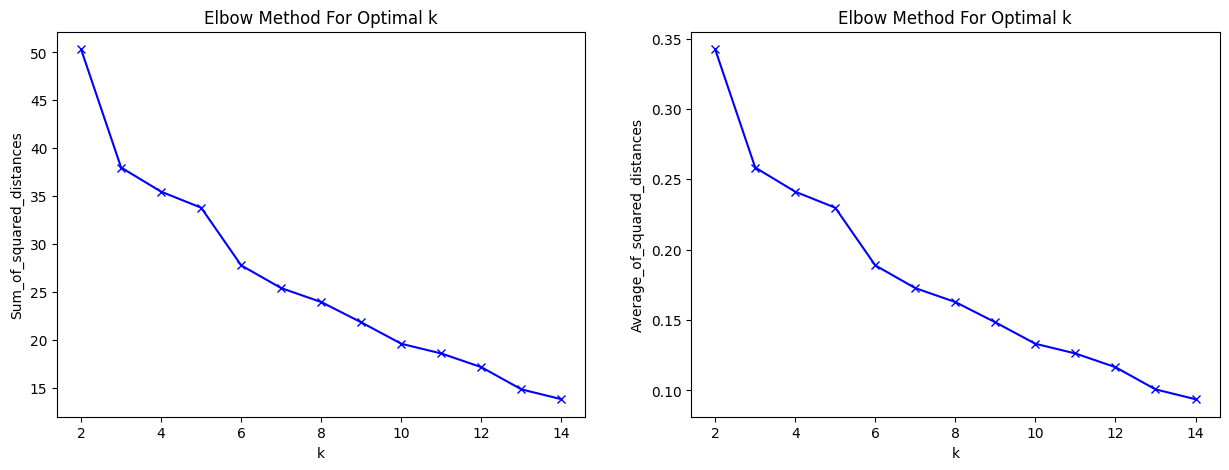

CPU times: total: 922 ms
Wall time: 698 ms


In [26]:
%%time
sum_of_squared_distances = []
average_of_squared_distances = []

K = range(2,15)
for k in K:
    km = KMeans(n_clusters=k, max_iter=500, random_state=42, n_init='auto')
    km = km.fit(df_train[features])
    sum_of_squared_distances.append(km.inertia_) 
    
    distortion = ((df_train[features] - km.cluster_centers_[km.predict(df_train[features])])**2.0).sum(axis=1).mean()
    average_of_squared_distances.append(distortion)
     
plt.figure(figsize=(15, 5))
plt.subplot( 1, 2, 1 )
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.subplot( 1, 2, 2 )
plt.plot(K, average_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Average_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

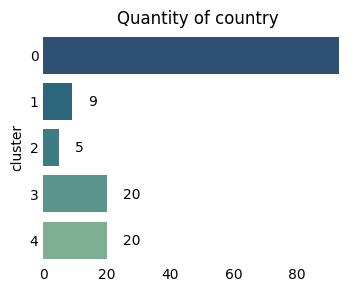

In [27]:
kmeans = KMeans(n_clusters=5, max_iter=500, random_state=42, n_init='auto')
labels = kmeans.fit_predict(df_train[features])
df_geolocation_abt['cluster'] = labels


# kmodes = KModes(n_clusters = 6, init = 'Cao', random_state = 0)
# df_geolocation_abt['cluster'] = kmodes.fit_predict(X_kmodes)

fig(4,3)
count_plot(df_geolocation_abt, cluster_col="cluster", palette='crest_r', title=f'Quantity of {geolocation_group}');

### DBSCAN

https://machinelearningmastery.com/clustering-algorithms-with-python/

https://towardsdatascience.com/how-to-use-dbscan-effectively-ed212c02e62

https://www.analyticsvidhya.com/blog/2020/09/how-dbscan-clustering-works/#:~:text=DBSCAN%20is%20a%20density%2Dbased,points%20into%20a%20single%20cluster

https://ml-explained.com/blog/dbscan-explained

https://crunchingthedata.com/when-to-use-dbscan/



Useful when you expect all of your clusters to have a similar density.

- **Advantages**

No need to specify the number of clusters as DBSCAN will automatically determine the clusters, dependent on how close points are from one another. 

It allows for noise and will not automatically determine the outliers are part of a particular cluster. 

It'll also do a strong job of handling arbitrary shapes as it's going to be searching out points that are within epsilon distance of one another, and will stop whenever a gap occurs no matter what that boundary shape between the clusters are.


- **Disadvantages**

It's going to require two parameters, which means we need to search over more possible values to find that optimal solution. Also those hyper parameters can be very difficult to fine tune in higher dimensional space.

If the dataset consists of clusters of varying density, the method may not give good results. It may not be the most appropriate if the data are very close together, and if the parameter ε cannot be estimated correctly.

It will not do well with clusters of different density. So even if we have two clear groups, if for one group the points are about five units away from one another, and the other is one unit away depending on our distance metric. Depending on that distance between our two clusters that are, on average five units away or one unit away, it may be difficult to determine the differentiation between those two clusters.

- **Statistical Assumptions**


Densities across all the clusters are the same.

Cluster sizes or standard deviations are the same.

Text(0, 0.5, 'Distance')

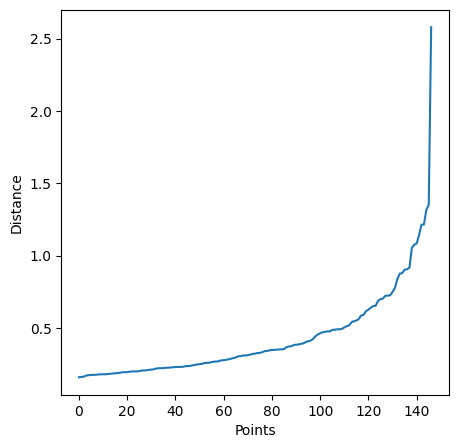

In [97]:
from sklearn.neighbors import NearestNeighbors
nearest_neighbors = NearestNeighbors(n_neighbors=50)
neighbors = nearest_neighbors.fit(df_train[features])
distances, indices = neighbors.kneighbors(df_train[features])
distances = np.sort(distances[:,10], axis=0)

fig(5, 5)
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance")

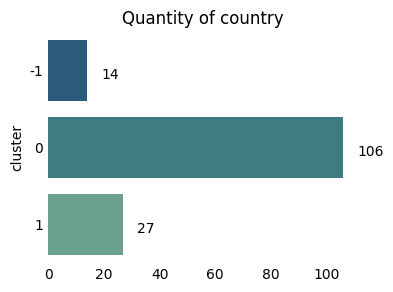

In [112]:
dbscan = DBSCAN(eps=.66, min_samples=int(len(df_train.columns)+1), ).fit(df_train[features]) # eps=.5, min_samples=15
df_geolocation_abt['cluster'] = dbscan.labels_

fig(4,3)
count_plot(df_geolocation_abt, cluster_col="cluster", palette='crest_r', title=f'Quantity of {geolocation_group}');

### Agglomerative Clustering

In [29]:
# 

## Feature Importances

In [69]:
y = df_geolocation_abt['cluster']

X_train, X_test, y_train, y_test = train_test_split(df_train, y, test_size=0.3, random_state=0)
pd.concat([y_train.value_counts(), y_test.value_counts()], axis=1)

,cluster,cluster
0,77,32
1,19,8
-1,6,5


In [70]:
random_forest_model = RandomForestClassifier(n_estimators=500, min_samples_leaf=5, random_state=0)
random_forest_model.fit(X_train, y_train)

y_pred = random_forest_model.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=1))

              precision    recall  f1-score   support

          -1       1.00      0.00      0.00         5
           0       0.86      1.00      0.93        32
           1       1.00      1.00      1.00         8

    accuracy                           0.89        45
   macro avg       0.95      0.67      0.64        45
weighted avg       0.90      0.89      0.84        45



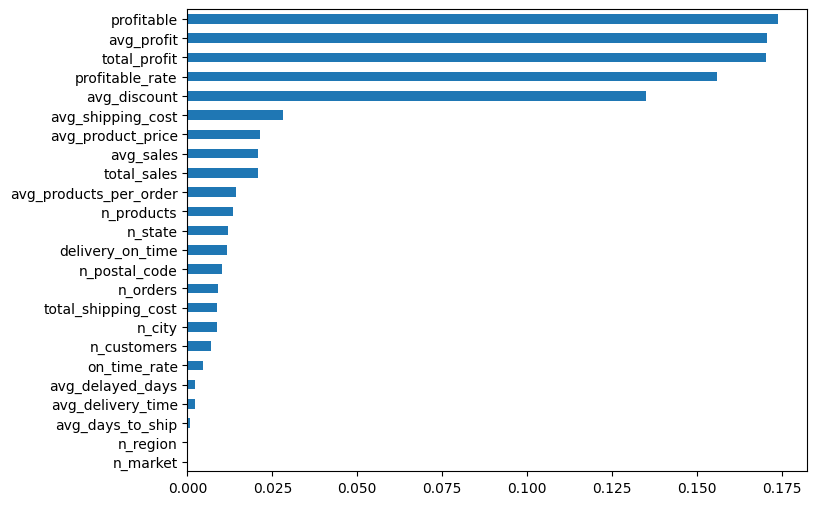

In [71]:
feature_importances = pd.Series(random_forest_model.feature_importances_, index=df_train.columns).sort_values(ascending=True)
feature_importances.plot.barh(figsize=(8, 6));

In [33]:
# feature_importances.tail(14).index

## Analysis

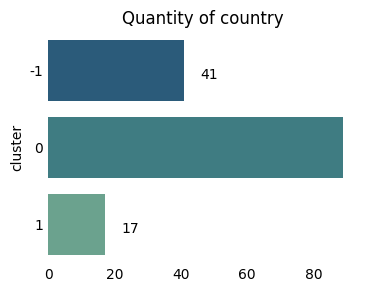

In [34]:
fig(4,3)
count_plot(df_geolocation_abt, cluster_col="cluster", palette='crest_r', title=f'Quantity of {geolocation_group}');

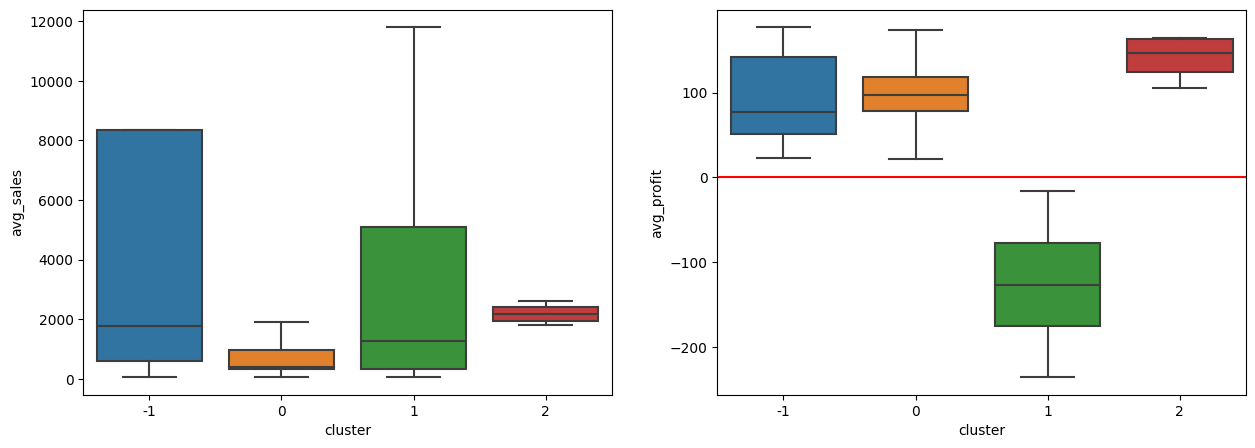

In [106]:
cluster_boxplot(cluster='cluster', y=['avg_sales', 'avg_profit'], data=df_geolocation_abt,
                showfliers=False)
plt.axhline(0, color='r');

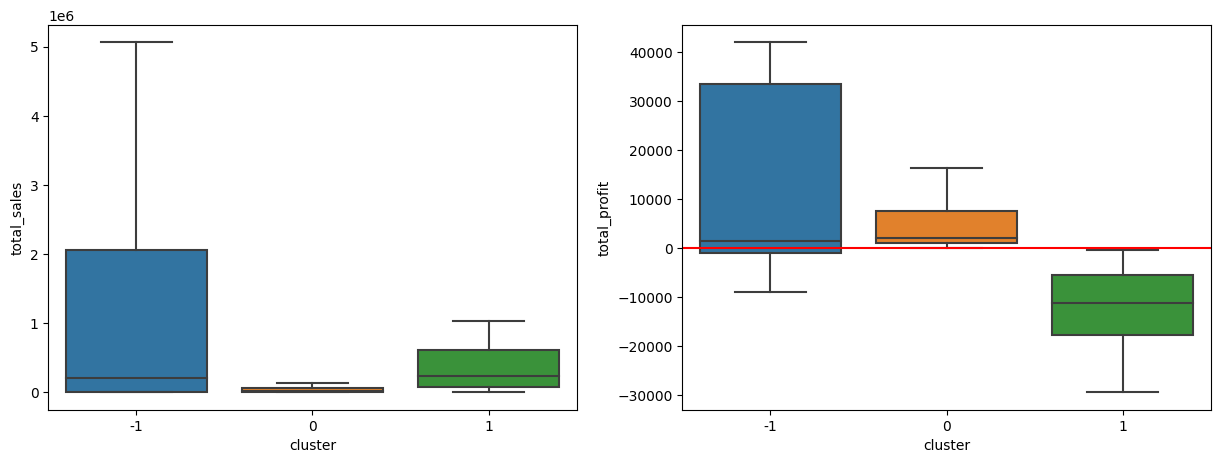

In [36]:
cluster_boxplot(cluster='cluster', y=['total_sales', 'total_profit'], data=df_geolocation_abt,
                showfliers=False)
plt.axhline(0, color='r');

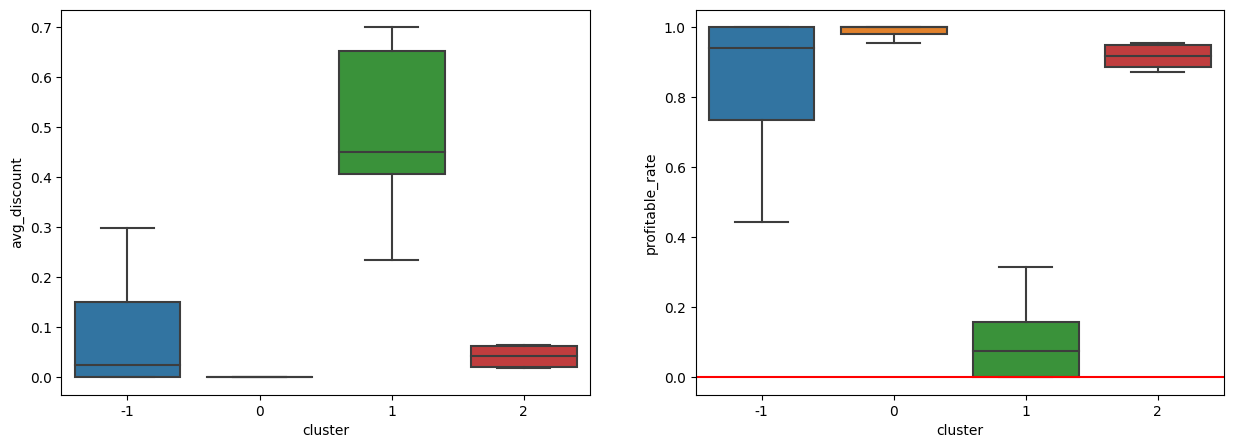

In [107]:
cluster_boxplot(cluster='cluster', y=['avg_discount', 'profitable_rate'], data=df_geolocation_abt,
                showfliers=False)
plt.axhline(0, color='r');

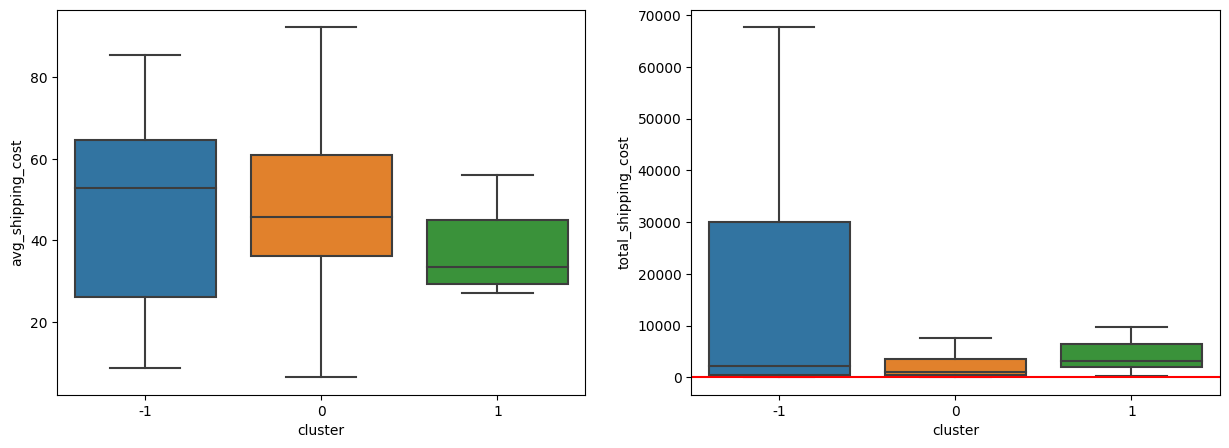

In [38]:
cluster_boxplot(cluster='cluster', y=['avg_shipping_cost', 'total_shipping_cost'], data=df_geolocation_abt,
                showfliers=False)
plt.axhline(0, color='r');

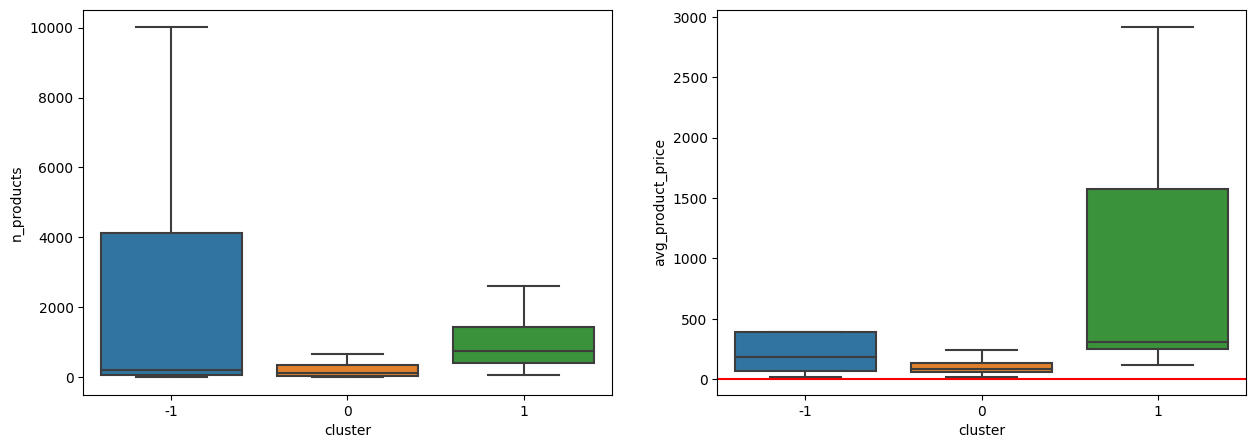

In [39]:
cluster_boxplot(cluster='cluster', y=['n_products', 'avg_product_price'], data=df_geolocation_abt,
                showfliers=False)
plt.axhline(0, color='r');

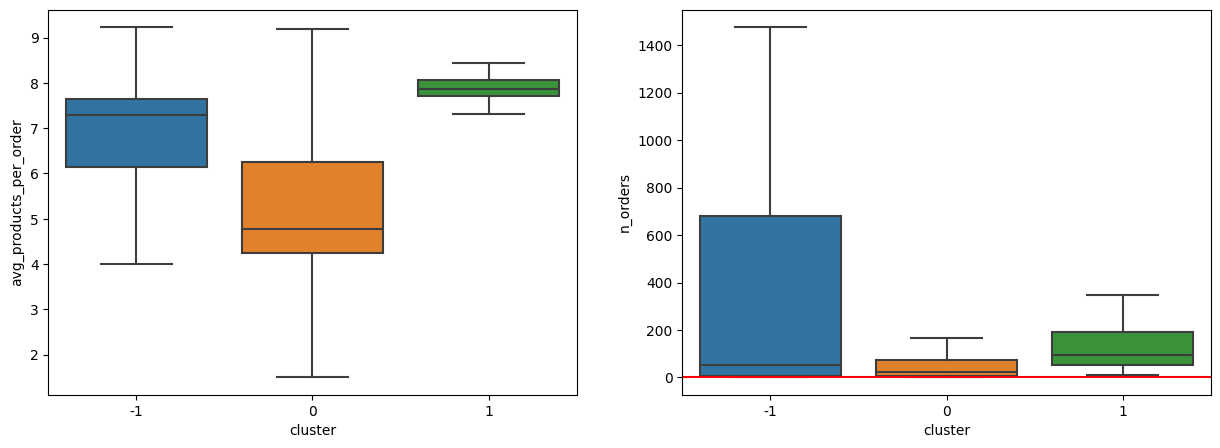

In [40]:
cluster_boxplot(cluster='cluster', y=['avg_products_per_order', 'n_orders'], data=df_geolocation_abt,
                showfliers=False)
plt.axhline(0, color='r');

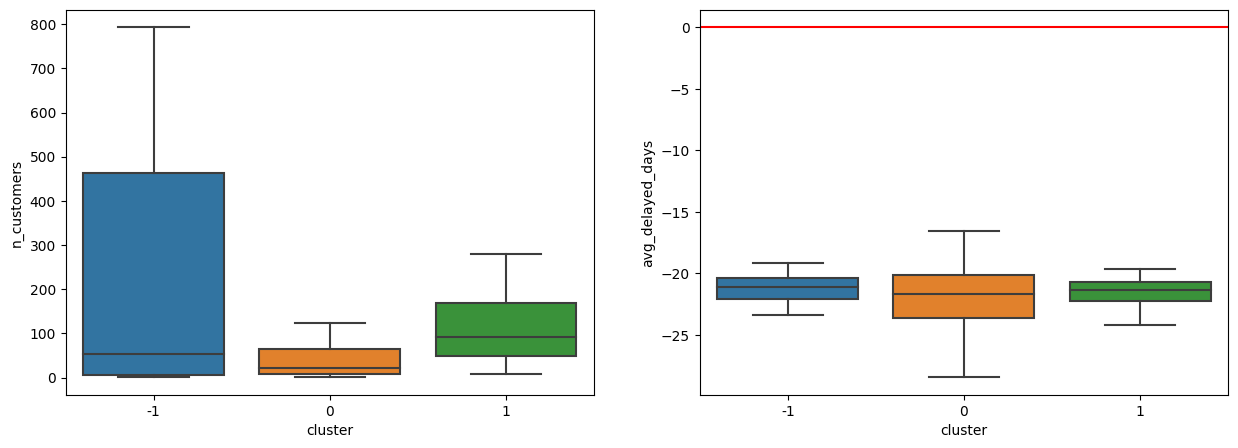

In [41]:
cluster_boxplot(cluster='cluster', y=['n_customers', 'avg_delayed_days'], data=df_geolocation_abt,
                showfliers=False)
plt.axhline(0, color='r');

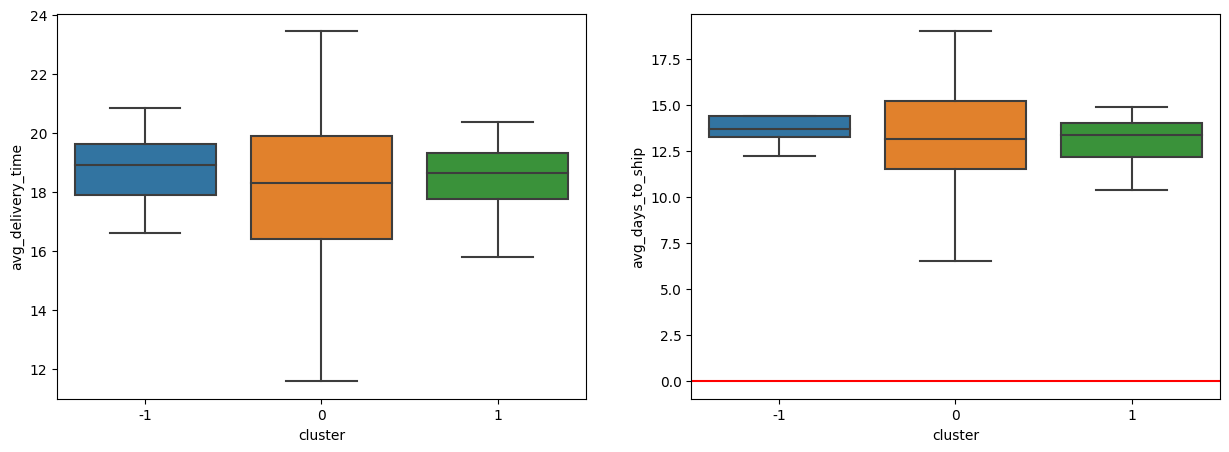

In [42]:
cluster_boxplot(cluster='cluster', y=['avg_delivery_time', 'avg_days_to_ship'], data=df_geolocation_abt,
                showfliers=False)
plt.axhline(0, color='r');

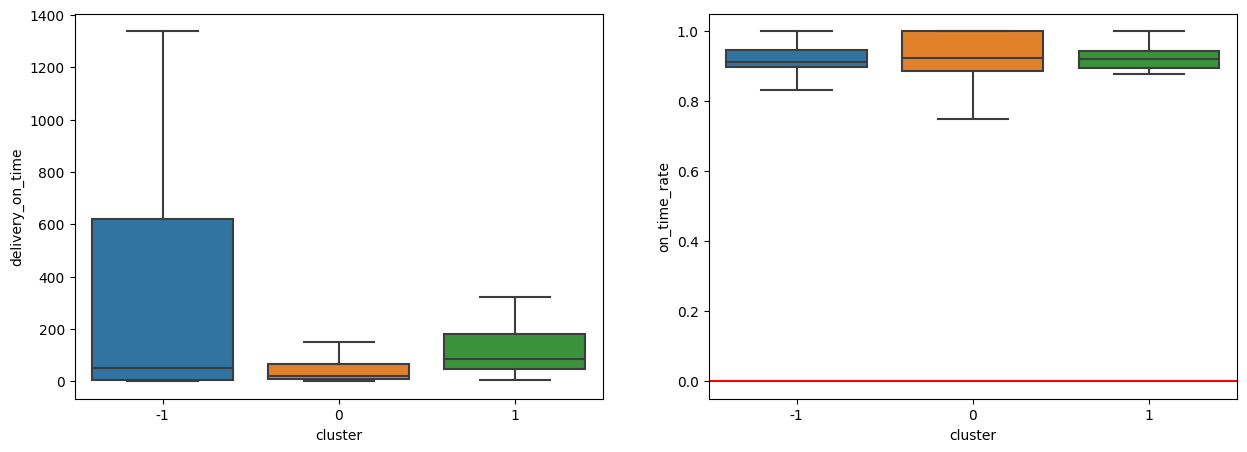

In [43]:
cluster_boxplot(cluster='cluster', y=['delivery_on_time', 'on_time_rate'], data=df_geolocation_abt,
                showfliers=False)
plt.axhline(0, color='r');

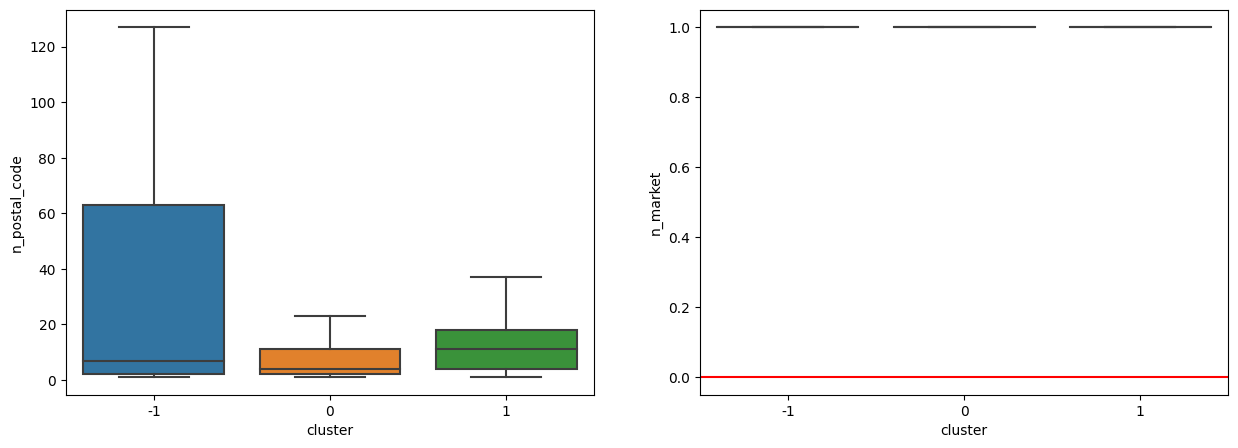

In [44]:
cluster_boxplot(cluster='cluster', y=['n_postal_code', 'n_market'], data=df_geolocation_abt,
                showfliers=False)
plt.axhline(0, color='r');

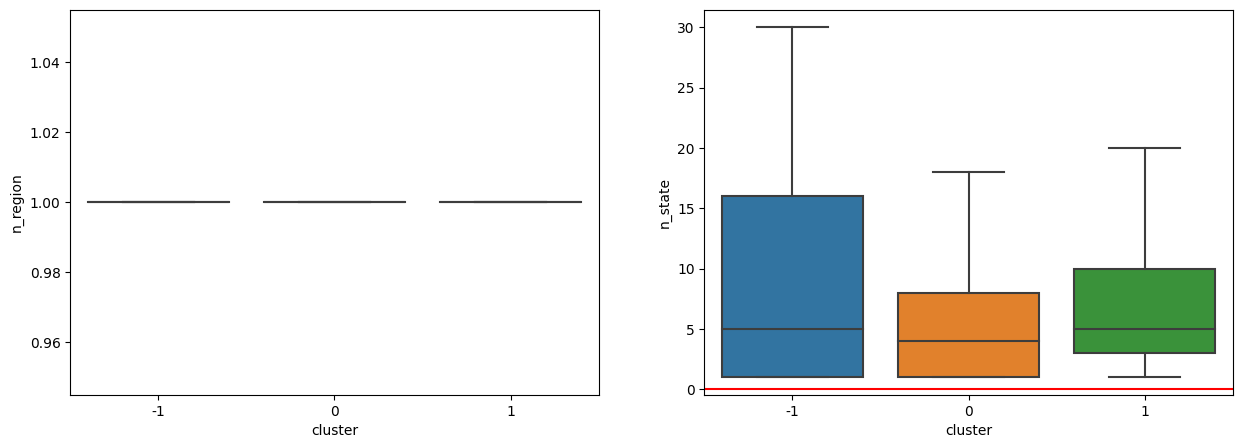

In [45]:
cluster_boxplot(cluster='cluster', y=['n_region', 'n_state'], data=df_geolocation_abt,
                showfliers=False)
plt.axhline(0, color='r');

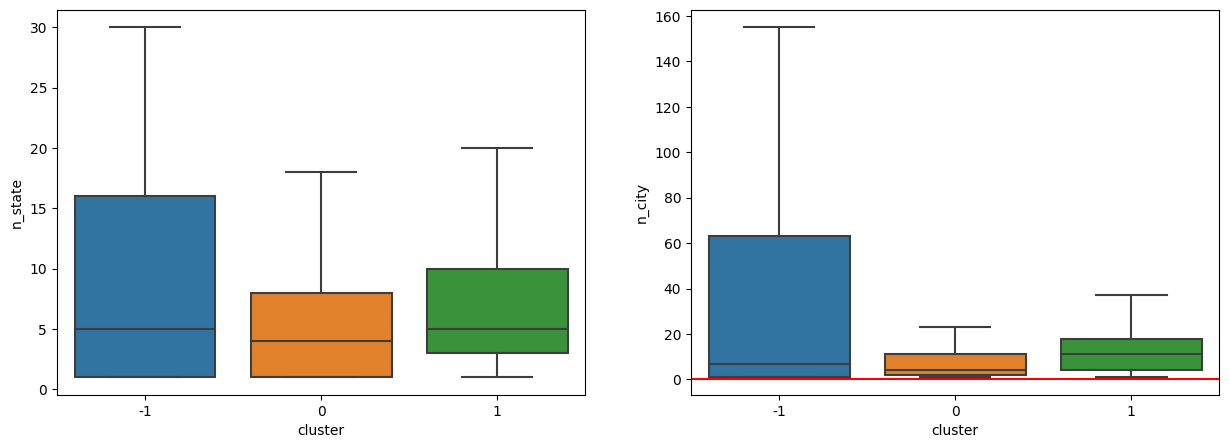

In [46]:
cluster_boxplot(cluster='cluster', y=['n_state', 'n_city'], data=df_geolocation_abt,
                showfliers=False)
plt.axhline(0, color='r');

In [47]:
df_geolocation_abt.columns

Index(['country', 'n_orders', 'n_customers', 'n_postal_code', 'n_market',
       'n_region', 'n_state', 'n_city', 'total_sales', 'avg_sales',
       'total_profit', 'avg_profit', 'avg_delivery_time', 'avg_days_to_ship',
       'avg_delayed_days', 'delivery_on_time', 'on_time_rate', 'n_products',
       'avg_products_per_order', 'avg_discount', 'avg_product_price',
       'total_shipping_cost', 'avg_shipping_cost', 'profitable_rate',
       'profitable', 'cluster'],
      dtype='object')

## Final Clusters 

In [48]:
df = df_orders.groupby(df_orders["order_date"])['order_id'].count().reset_index()

In [49]:
df['media'] = df['order_id'].mean()

In [50]:
df['max'] =  df['order_id'].mean()+(df['order_id'].std()*3)
df['min'] =  df['order_id'].mean()-(df['order_id'].std()*3)

<Axes: >

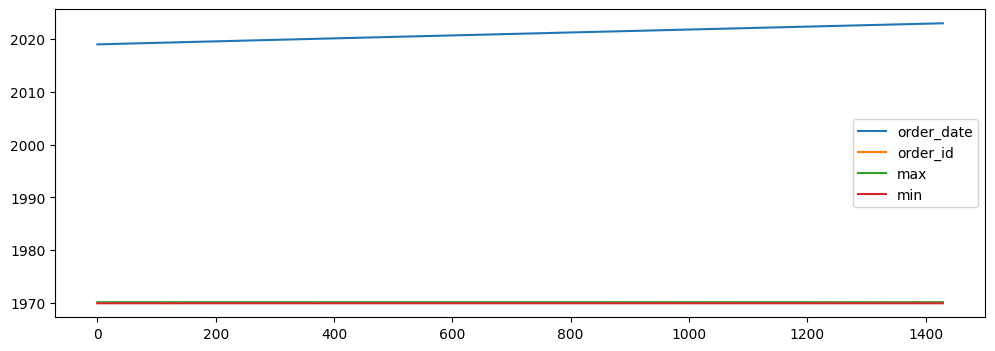

In [51]:
df.drop(columns='media').plot()

In [52]:
df['order_id'].mean()

18.009090909090908

In [53]:
df[(df['order_id'] >= df['min']) & (df['order_id'] <= df['max'])]['order_id'].mean()

17.764250527797326

<Axes: >

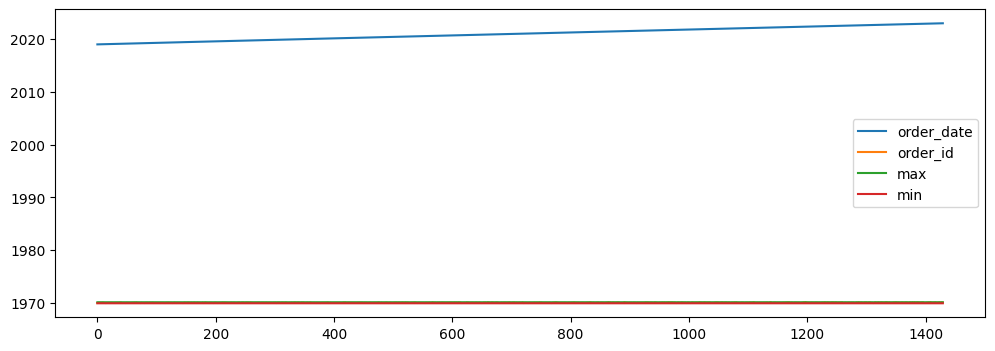

In [54]:
df[(df['order_id'] >= df['min']) & (df['order_id'] <= df['max'])].drop(columns='media').plot()

<Axes: >

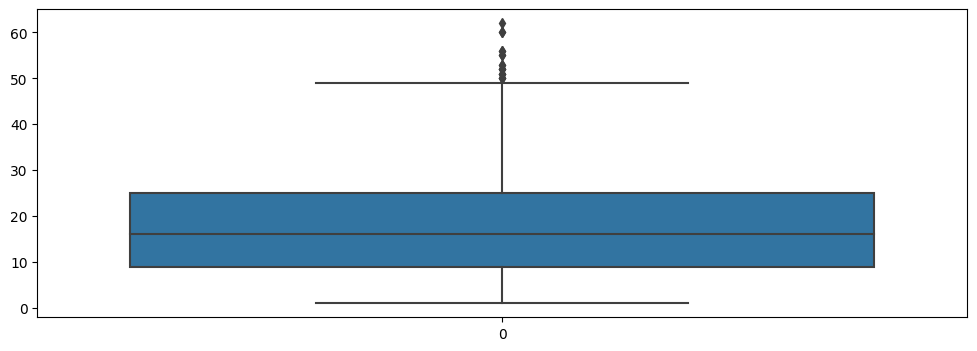

In [55]:
sns.boxplot(df['order_id'], showfliers=True)

<Axes: >

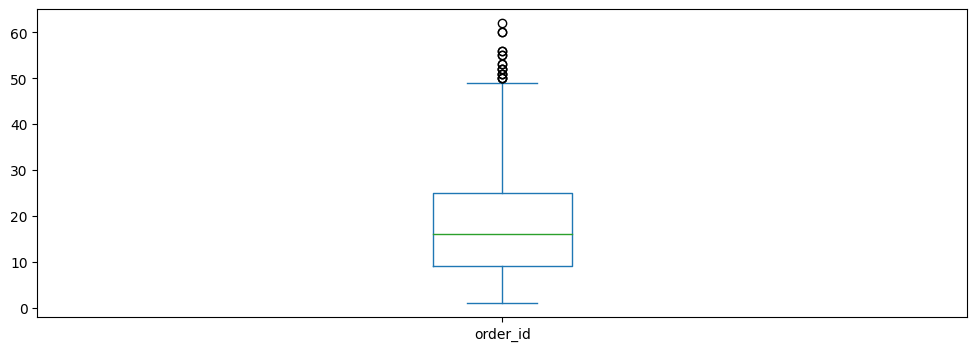

In [56]:
df['order_id'].plot.box()